In [ ]:
!pip install -U gensim
!pip install -U scipy~=1.13.0
!pip install -U Cython
from sklearn.decomposition import PCA
import gensim
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
word2vec_path='/content/drive/My Drive/Datasets/glove.6B.300d.bin'
analogies_path='/content/drive/My Drive/Datasets/questions-words.txt'

In [ ]:
drive.mount('/content/drive')

# Load the Word2Vec model directly from the Google Drive file path
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Example: Check similarity between two words
similarity = word2vec_model.similarity('man', 'woman')
print(f"Similarity between 'man' and 'woman': {similarity}")

Mounted at /content/drive
Similarity between 'man' and 'woman': 0.6998662948608398


In [ ]:
# Read the file, skipping lines starting with ':'
df = pd.read_csv(analogies_path, delimiter=" ", header=None, comment=":")

# Assign column names
df.columns = ["word_a", "word_b", "word_c", "word_d"]

# Display the first few rows
print(df.head())

   word_a  word_b   word_c       word_d
0  Athens  Greece  Baghdad         Iraq
1  Athens  Greece  Bangkok     Thailand
2  Athens  Greece  Beijing        China
3  Athens  Greece   Berlin      Germany
4  Athens  Greece     Bern  Switzerland


In [ ]:
def find_gender_direction():
    """Finds and returns a 'gender direction'."""
    gender_biased_word_pairs = [
        ("she", "he"),
        ("her", "his"),
        ("woman", "man"),
        ("Mary", "John"),
        ("herself", "himself"),
        ("daughter", "son"),
        ("mother", "father"),
        ("gal", "guy"),
        ("girl", "boy"),
        ("vagina", "penis"),
        ("feminine", "masculine")
    ]

    # Filter out missing words
    valid_pairs = [(pair[0], pair[1]) for pair in gender_biased_word_pairs if pair[0] in word2vec_model and pair[1] in word2vec_model]

    # Compute bias vectors
    biases = [word2vec_model[pair[0]] - word2vec_model[pair[1]] for pair in valid_pairs]
    reversed_biases = [word2vec_model[pair[1]] - word2vec_model[pair[0]] for pair in valid_pairs]

    # Normalize bias vectors before PCA
    biases = [vec / np.linalg.norm(vec) for vec in biases]
    reversed_biases = [vec / np.linalg.norm(vec) for vec in reversed_biases]

    # Perform PCA
    pca = PCA(n_components=1)
    pca.fit(np.array(biases + reversed_biases))

    # Normalize the gender direction
    gender_direction = pca.components_[0]
    gender_direction = gender_direction / np.linalg.norm(gender_direction)

    return gender_direction


In [ ]:
gender_direction=find_gender_direction()
print(gender_direction.shape)

(300,)


In [ ]:
class AdversarialBiasMitigation(tf.keras.Model):
    def __init__(self, input_dim):
        super().__init__()

        # Predictor network (X → Y)
        self.predictor = tf.keras.Sequential([
            tf.keras.layers.Dense(input_dim, activation='linear',use_bias=False)  # Output: Y (continuous)
        ])

        # Adversary network (Y → Z)
        self.adversary = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation='linear',use_bias=False)  # Output: Z (e.g., bias attribute)
        ])

    def call(self, x):
        y_pred = self.predictor(x)
        z_pred = self.adversary(y_pred)
        return y_pred, z_pred

    def debias(self, biased_word_or_embedding):
      # Check if input is a string (word) or an array (embedding)
      if isinstance(biased_word_or_embedding, str):
        embedding = word2vec_model[biased_word_or_embedding]  # Get embedding if word
      else:
        embedding = biased_word_or_embedding  # Use as is if embedding

      # Ensure the input is a TensorFlow tensor
      embedding = tf.convert_to_tensor(embedding, dtype=tf.float32)

      # Add a batch dimension explicitly
      embedding = tf.expand_dims(embedding, axis=0)  # Shape: (1, input_dim)

      # Pass through the predictor network to get the debiased embedding
      debiased_embedding = self.predictor(embedding).numpy()[0]  # Remove batch dimension

      return debiased_embedding



def project(grad_W_L1, grad_W_L2):
    """
    Calculates the projection of grad_W_L1 onto grad_W_L2.

    """
    # Validate input
    assert len(grad_W_L1) == len(grad_W_L2), "Gradient lists must have the same length"

    # Compute dot product
    dot_product = tf.add_n([tf.reduce_sum(tf.multiply(g1, g2)) for g1, g2 in zip(grad_W_L1, grad_W_L2)])

    # Compute norm of grad_W_L2
    norm_W_L2 = tf.add_n([tf.reduce_sum(tf.square(g2)) for g2 in grad_W_L2])

    # Avoid division by zero
    norm_W_L2 = tf.maximum(norm_W_L2, tf.keras.backend.epsilon())

    # Compute scaling factor
    scale = dot_product / norm_W_L2

    # Compute projection
    projection = [scale * g2 for g2 in grad_W_L2]

    return projection



# Training step
def train_step(model, x, y, z, optimizer_W, optimizer_U, loss_fn_Y, loss_fn_Z):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        y_pred, z_pred = model(x)

        # Compute losses
        loss_WL1 = loss_fn_Y(y, y_pred)  # Predictor loss (L1)
        loss_UL2 = loss_fn_Z(z, z_pred)  # Adversary loss (L2)

    # Gradients w.r.t predictor (W) for both losses
    grads_WL1 = tape.gradient(loss_WL1, model.predictor.trainable_variables)
    grads_WL2 = tape.gradient(loss_UL2, model.predictor.trainable_variables)

    # Gradients w.r.t adversary (U)
    grads_UL2 = tape.gradient(loss_UL2, model.adversary.trainable_variables)

    # Project ∇WL1 onto ∇WL2
    proj_WL1_WL2 = project(grads_WL1, grads_WL2)


    modified_grads_WL1 = []

    # Subtract both projection and grad_W_L2 from grad_W_L1 while preserving structure
    for g1, p, g2 in zip(grads_WL1, proj_WL1_WL2, grads_WL2):
        modified_grad = g1 - p - g2
        modified_grads_WL1.append(modified_grad)




    # Apply gradients to predictor (using modified gradients)
    optimizer_W.apply_gradients(zip(modified_grads_WL1, model.predictor.trainable_variables))

    # Apply gradients to adversary
    optimizer_U.apply_gradients(zip(grads_UL2, model.adversary.trainable_variables))

    return loss_WL1, loss_UL2





In [ ]:
# INSTANTIATE THE MODEL

input_dim = 300  # Dimension of word embeddings
hidden_dim = 128

# Instantiate model
model = AdversarialBiasMitigation(input_dim=input_dim)

# Optimizers 0.001 0.005 2**-16
optimizer_W = tf.keras.optimizers.Adam(learning_rate=2**-16)
optimizer_U = tf.keras.optimizers.Adam(learning_rate=2**-16)

# Loss functions
loss_fn_Y = tf.keras.losses.MeanSquaredError()  # For predictor
loss_fn_Z = tf.keras.losses.MeanSquaredError()  # For adversary

In [ ]:
# Compute X, Y, and Z
X, Y, Z = [], [], []

for _, row in df.iterrows():
    # Check if all words in the row are in the vocabulary
    words = [row['word_a'], row['word_b'], row['word_c'], row['word_d']]
    if not all(word in word2vec_model for word in words):
        continue  # Skip this row if any word is missing

    # Feature: X = -word_a + word_b + word_c (based on your query)
    word_a_vec = word2vec_model[row['word_a']]
    word_b_vec = word2vec_model[row['word_b']]
    word_c_vec = word2vec_model[row['word_c']]
    feature_vec = -word_a_vec + word_b_vec + word_c_vec
    X.append(feature_vec)

    # Label: Y = word_d vector
    word_d_vec = word2vec_model[row['word_d']]
    Y.append(word_d_vec)

    # Bias attribute: Z = scalar projection of word_d onto gender_direction
    Z.append(np.dot(word_d_vec, gender_direction))  # Scalar value

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z).reshape(-1, 1)  # Convert to 2D array (batch_size, 1)

print(X.shape)
print(Y.shape)
print(Z.shape)

(9582, 300)
(9582, 300)
(9582, 1)


In [ ]:
def create_batches(X, Y, Z, batch_size):
    """Create shuffled batches of data."""
    data_size = len(X)
    indices = np.random.permutation(data_size)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    Z_shuffled = Z[indices]

    batches = []
    for i in range(0, data_size, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        Z_batch = Z_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch, Z_batch))
    return batches

In [ ]:
batch_size = 64
batches = create_batches(X, Y, Z, batch_size)
print(len(batches[0][0]))

64


Epoch 1: Loss_Y=0.590224, Loss_Z=57.700249
Epoch 10: Loss_Y=0.887425, Loss_Z=45.642315
Epoch 20: Loss_Y=1.065739, Loss_Z=16.535165
Epoch 30: Loss_Y=1.097735, Loss_Z=3.465224
Epoch 40: Loss_Y=1.056918, Loss_Z=0.772041
Epoch 50: Loss_Y=1.038289, Loss_Z=1.439431
  ↳ Avg Analogy Rank (sampled) = 460.00
Epoch 60: Loss_Y=1.004722, Loss_Z=0.634797
Epoch 70: Loss_Y=0.818146, Loss_Z=0.242798
Epoch 80: Loss_Y=0.586807, Loss_Z=0.263087
Epoch 90: Loss_Y=0.382682, Loss_Z=0.303457
Epoch 100: Loss_Y=0.252573, Loss_Z=0.334480
  ↳ Avg Analogy Rank (sampled) = 115.44
Epoch 110: Loss_Y=0.167539, Loss_Z=0.340867
Epoch 120: Loss_Y=0.119094, Loss_Z=0.342262
Epoch 130: Loss_Y=0.094460, Loss_Z=0.342395
Epoch 140: Loss_Y=0.079899, Loss_Z=0.342106
Epoch 150: Loss_Y=0.069859, Loss_Z=0.341876
  ↳ Avg Analogy Rank (sampled) = 6.06
Epoch 160: Loss_Y=0.062683, Loss_Z=0.341916
Epoch 170: Loss_Y=0.057612, Loss_Z=0.341576
Epoch 180: Loss_Y=0.053778, Loss_Z=0.341787
Epoch 190: Loss_Y=0.050959, Loss_Z=0.341526
Epoch 200:

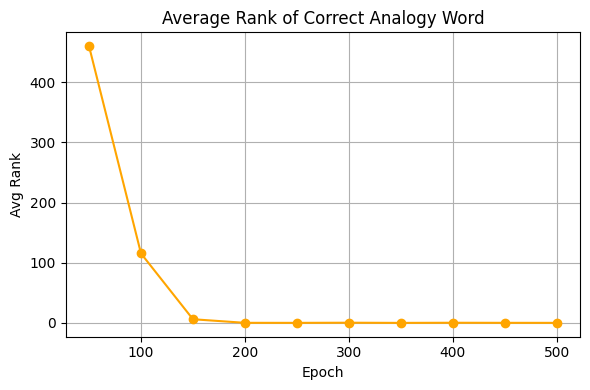

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Step 1: Extract analogies from your DataFrame
analogies = list(zip(df['word_a'], df['word_b'], df['word_c'], df['word_d']))

# Step 2: Define function to evaluate analogy quality (semantic preservation)
def average_rank_of_correct(model, analogies):
    total_rank = 0
    for a, b, c, d in analogies:
        try:
            vec = word2vec_model[b] + word2vec_model[c] - word2vec_model[a]
            debiased = model.debias(vec)
            sims = word2vec_model.similar_by_vector(debiased, topn=1000)
            rank = next((i for i, (word, _) in enumerate(sims) if word == d), 1000)
            total_rank += rank
        except KeyError:
            continue  # Skip analogies with OOV words
    return total_rank / len(analogies)

# Step 3: Set up tracking and stopping parameters
patience = 5
no_improve = 0
optimal_epoch = 0
eval_interval = 50
last_rank = None
rank_history = []
metric_epochs = []

# Step 4: Training loop with semantic early stopping using random sample
for epoch in range(500):
    total_loss_Y = 0.0
    total_loss_Z = 0.0

    for X_batch, Y_batch, Z_batch in batches:
        batch_loss_Y, batch_loss_Z = train_step(
            model,
            X_batch,
            Y_batch,
            Z_batch,
            optimizer_W,
            optimizer_U,
            loss_fn_Y,
            loss_fn_Z,
        )
        total_loss_Y += batch_loss_Y.numpy()
        total_loss_Z += batch_loss_Z.numpy()

    avg_loss_Y = total_loss_Y / len(batches)
    avg_loss_Z = total_loss_Z / len(batches)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: Loss_Y={avg_loss_Y:.6f}, Loss_Z={avg_loss_Z:.6f}")

    if (epoch + 1) % eval_interval == 0:
        # Sample 200 analogies randomly for fast eval
        sampled_analogies = random.sample(analogies, k=200)
        avg_rank = average_rank_of_correct(model, sampled_analogies)
        rank_history.append(avg_rank)
        metric_epochs.append(epoch + 1)
        print(f"  ↳ Avg Analogy Rank (sampled) = {avg_rank:.2f}")

        if last_rank is not None:
            rank_delta = last_rank - avg_rank
            if rank_delta <= 0:
                no_improve += 1
            else:
                no_improve = 0

            if no_improve >= patience:
                optimal_epoch = epoch + 1
                print(f"Early stopping (semantic) at epoch {optimal_epoch}")
                break

        last_rank = avg_rank

# Step 5: Final fallback
if optimal_epoch == 0:
    optimal_epoch = epoch + 1
    print(f"Finished all {optimal_epoch} epochs (no early convergence)")

# Step 6: Plot the average rank over training
plt.figure(figsize=(6, 4))
plt.plot(metric_epochs, rank_history, marker='o', color='orange')
plt.title("Average Rank of Correct Analogy Word")
plt.xlabel("Epoch")
plt.ylabel("Avg Rank")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1: Loss_Y=0.323142, Loss_Z=1.639883
Epoch 10: Loss_Y=0.559882, Loss_Z=52.127430
  ↳ Avg Analogy Rank (sampled) = 535.00
Epoch 20: Loss_Y=0.870815, Loss_Z=39.919835
  ↳ Avg Analogy Rank (sampled) = 515.00
Epoch 30: Loss_Y=1.036861, Loss_Z=14.993789
  ↳ Avg Analogy Rank (sampled) = 490.00
Epoch 40: Loss_Y=1.069713, Loss_Z=3.239730
  ↳ Avg Analogy Rank (sampled) = 520.00
Epoch 50: Loss_Y=1.026636, Loss_Z=0.772156
  ↳ Avg Analogy Rank (sampled) = 494.84
Epoch 60: Loss_Y=1.001063, Loss_Z=1.281657
  ↳ Avg Analogy Rank (sampled) = 438.64
Epoch 70: Loss_Y=0.956866, Loss_Z=0.609872
  ↳ Avg Analogy Rank (sampled) = 515.00
Epoch 80: Loss_Y=0.774957, Loss_Z=0.230030
  ↳ Avg Analogy Rank (sampled) = 477.49
Epoch 90: Loss_Y=0.552270, Loss_Z=0.240642
  ↳ Avg Analogy Rank (sampled) = 511.46
Epoch 100: Loss_Y=0.363220, Loss_Z=0.265525
  ↳ Avg Analogy Rank (sampled) = 245.03
Epoch 110: Loss_Y=0.235515, Loss_Z=0.317475
  ↳ Avg Analogy Rank (sampled) = 115.36
Epoch 120: Loss_Y=0.164238, Loss_Z=0.340

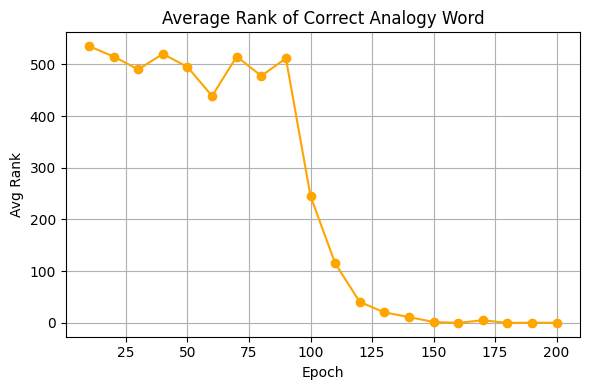

In [ ]:
# Step 1: Extract analogies from your DataFrame
analogies = list(zip(df['word_a'], df['word_b'], df['word_c'], df['word_d']))

# Step 2: Define function to evaluate analogy quality (semantic preservation)
def average_rank_of_correct(model, analogies):
    total_rank = 0
    for a, b, c, d in analogies:
        try:
            vec = word2vec_model[b] + word2vec_model[c] - word2vec_model[a]
            debiased = model.debias(vec)
            sims = word2vec_model.similar_by_vector(debiased, topn=1000)
            rank = next((i for i, (word, _) in enumerate(sims) if word == d), 1000)
            total_rank += rank
        except KeyError:
            continue  # Skip analogies with OOV words
    return total_rank / len(analogies)

# Step 3: Re-instantiate the model and setup
model = AdversarialBiasMitigation(input_dim=300)
optimizer_W = tf.keras.optimizers.Adam(learning_rate=2**-16)
optimizer_U = tf.keras.optimizers.Adam(learning_rate=2**-16)
loss_fn_Y = tf.keras.losses.MeanSquaredError()
loss_fn_Z = tf.keras.losses.MeanSquaredError()

# Step 4: Set up tracking for early stopping
patience = 3
no_improve = 0
optimal_epoch = 0
last_rank = None
rank_history = []
metric_epochs = []
eval_interval = 10

# Step 5: Training loop with semantic early stopping
for epoch in range(200):
    total_loss_Y = 0.0
    total_loss_Z = 0.0

    for X_batch, Y_batch, Z_batch in batches:
        batch_loss_Y, batch_loss_Z = train_step(
            model,
            X_batch,
            Y_batch,
            Z_batch,
            optimizer_W,
            optimizer_U,
            loss_fn_Y,
            loss_fn_Z,
        )
        total_loss_Y += batch_loss_Y.numpy()
        total_loss_Z += batch_loss_Z.numpy()

    avg_loss_Y = total_loss_Y / len(batches)
    avg_loss_Z = total_loss_Z / len(batches)

    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}: Loss_Y={avg_loss_Y:.6f}, Loss_Z={avg_loss_Z:.6f}")

    if (epoch + 1) % eval_interval == 0:
        sampled_analogies = random.sample(analogies, k=200)
        avg_rank = average_rank_of_correct(model, sampled_analogies)
        rank_history.append(avg_rank)
        metric_epochs.append(epoch + 1)
        print(f"  ↳ Avg Analogy Rank (sampled) = {avg_rank:.2f}")

        if last_rank is not None:
            rank_delta = last_rank - avg_rank  # improvement
            if rank_delta <= 0:
                no_improve += 1
            else:
                no_improve = 0

            if no_improve >= patience:
                optimal_epoch = epoch + 1
                print(f" Early stopping (semantic) at epoch {optimal_epoch}")
                break

        last_rank = avg_rank

# Step 6: Final fallback
if optimal_epoch == 0:
    optimal_epoch = epoch + 1
    print(f" Finished all {optimal_epoch} epochs (no early convergence)")

# Step 7: Plot the average rank over training
plt.figure(figsize=(6, 4))
plt.plot(metric_epochs, rank_history, marker='o', color='orange')
plt.title("Average Rank of Correct Analogy Word")
plt.xlabel("Epoch")
plt.ylabel("Avg Rank")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Save model weights
model.save_weights('/content/drive/MyDrive/MyModels/debias_glove_weights.weights.h5')

# Loading the Trained Model

In [ ]:
# Reconstruct the architecture
loaded_model = AdversarialBiasMitigation(input_dim=300)

# Pass dummy data through the model to implicitly build it
dummy_input = tf.random.normal([1, 300])  # Batch size = 1, input_dim = 300
_ = loaded_model(dummy_input)  # Forward pass to initialize and build the model


# Load weights into the new model instance
loaded_model.load_weights('/content/drive/MyDrive/MyModels/debias_glove_weights.weights.h5')


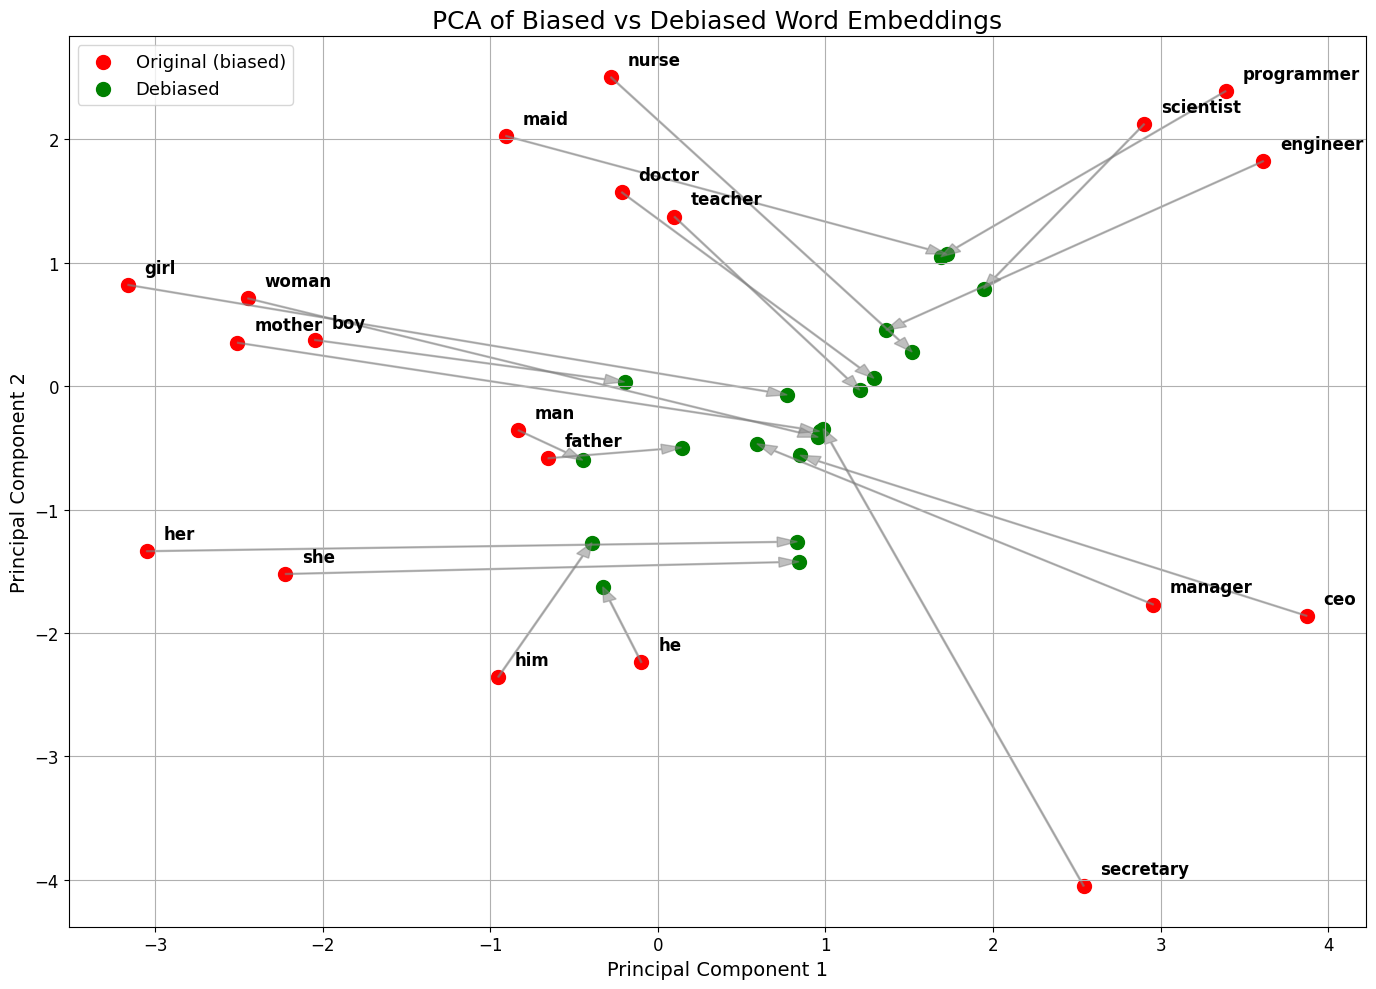

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Word list

biased_words = [
    'nurse', 'doctor', 'teacher', 'engineer', 'scientist',
    'maid', 'ceo', 'secretary', 'programmer', 'manager',
    'mother', 'father', 'she', 'he', 'her', 'him',
    'woman', 'man', 'girl', 'boy'
]

# Get vectors
original_vectors = []
debiased_vectors = []
labels = []

for word in biased_words:
    if word in word2vec_model:
        vec = word2vec_model[word]
        debiased_vec = loaded_model.debias(vec)
        original_vectors.append(vec)
        debiased_vectors.append(debiased_vec)
        labels.append(word)

# PCA
pca = PCA(n_components=2)
original_2d = pca.fit_transform(np.array(original_vectors))
debiased_2d = pca.transform(np.array(debiased_vectors))

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(original_2d[:, 0], original_2d[:, 1], color='red', label='Original (biased)', s=100)
plt.scatter(debiased_2d[:, 0], debiased_2d[:, 1], color='green', label='Debiased', s=100)

# Arrows + smart offset labels
for i, word in enumerate(labels):
    x0, y0 = original_2d[i]
    x1, y1 = debiased_2d[i]

    plt.arrow(
        x0, y0, x1 - x0, y1 - y0,
        color='gray', alpha=0.5, width=0.008, head_width=0.08, length_includes_head=True
    )

    # Label near original (red) point, offset diagonally
    label_offset = 0.1
    plt.text(
        x0 + label_offset, y0 + label_offset,
        word, fontsize=12, fontweight='bold', color='black'
    )

plt.title('PCA of Biased vs Debiased Word Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()


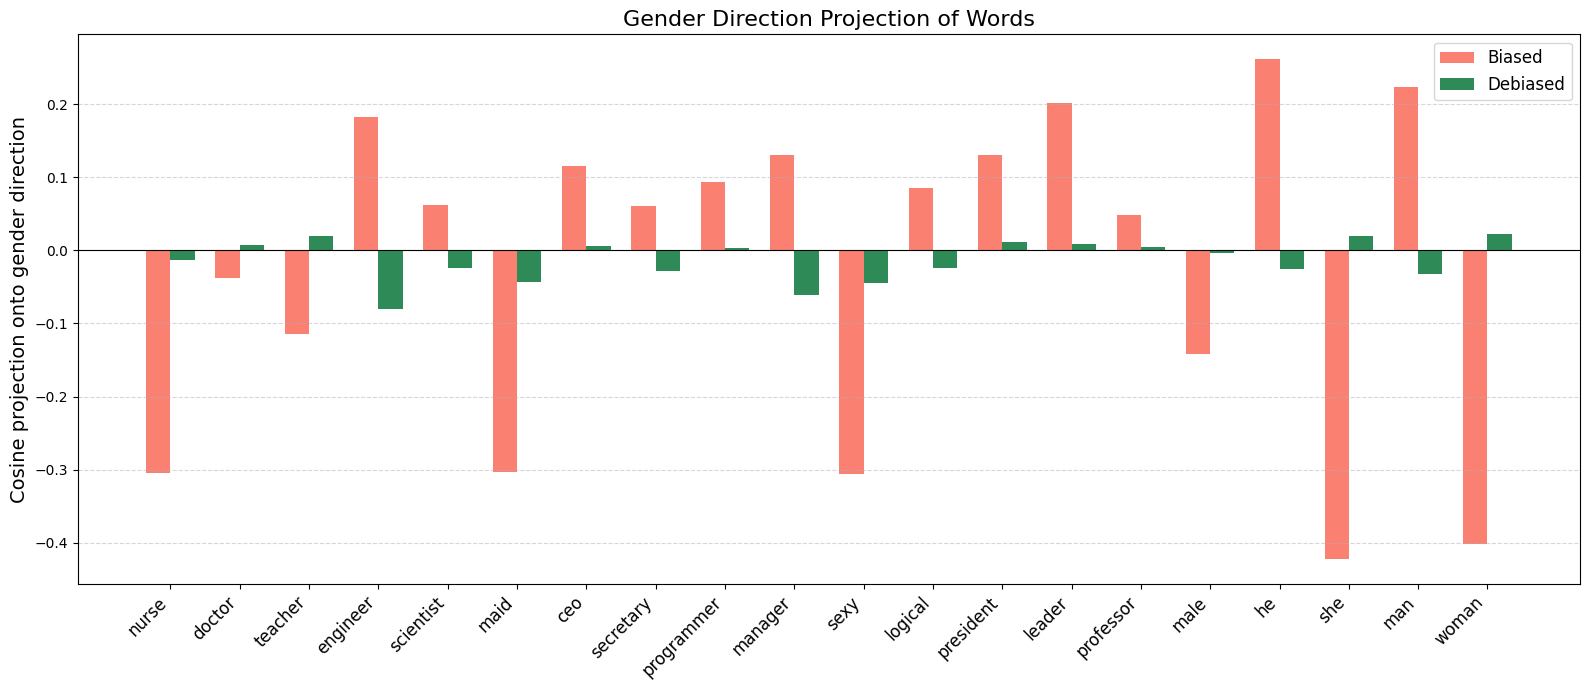

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pca_words = [
    'nurse', 'doctor', 'teacher', 'engineer', 'scientist',
    'maid', 'ceo', 'secretary', 'programmer', 'manager','sexy','logical',
    'president','leader','professor','male','he','femal','she','man','woman'
]

# Helper: cosine projection onto gender direction
def cosine_proj(v, d):
    return np.dot(v, d) / (np.linalg.norm(v) * np.linalg.norm(d))

# Store projections
biased_proj = []
debiased_proj = []
final_words = []

for word in pca_words:
    if word in word2vec_model:
        vec = word2vec_model[word]
        debiased_vec = loaded_model.debias(vec)
        biased_proj.append(cosine_proj(vec, gender_direction))
        debiased_proj.append(cosine_proj(debiased_vec, gender_direction))
        final_words.append(word)

# Plot
x = np.arange(len(final_words))
bar_width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(x - bar_width/2, biased_proj, bar_width, color='salmon', label='Biased')
plt.bar(x + bar_width/2, debiased_proj, bar_width, color='seagreen', label='Debiased')

plt.xticks(x, final_words, rotation=45, ha='right', fontsize=12)
plt.ylabel('Cosine projection onto gender direction', fontsize=14)
plt.title('Gender Direction Projection of Words', fontsize=16)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def weat_effect_size(X, Y, A, B, model):
    """Compute the WEAT effect size for target sets X, Y and attribute sets A, B"""
    def s(w, A, B):
        return np.mean([cosine_similarity(model[w], model[a]) for a in A]) - \
               np.mean([cosine_similarity(model[w], model[b]) for b in B])
    s_X = np.array([s(w, A, B) for w in X])
    s_Y = np.array([s(w, A, B) for w in Y])
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(np.concatenate([s_X, s_Y]))

def weat_score(X, Y, A, B, model):
    """Compute the raw WEAT score (not normalized)"""
    def s(w, A, B):
        return np.mean([cosine_similarity(model[w], model[a]) for a in A]) - \
               np.mean([cosine_similarity(model[w], model[b]) for b in B])
    return np.sum([s(w, A, B) for w in X]) - np.sum([s(w, A, B) for w in Y])

# Target (profession) words (use subset or all 20 from PCA)
X = ['engineer', 'scientist', 'programmer', 'manager', 'doctor']
Y = ['nurse', 'maid', 'secretary', 'teacher']

# Attribute (gender) words
A = ['he', 'him', 'man']
B = ['she', 'her', 'woman']

# Run WEAT on original (biased) model
weat_orig = weat_effect_size(X, Y, A, B, word2vec_model)
print(f"WEAT effect size (original): {weat_orig:.4f}")

# Run WEAT on debiased embeddings
def get_debiased_dict(words, model, debias_func):
    return {w: debias_func(model[w]) for w in words}

# Combine all words needed
all_words = list(set(X + Y + A + B))
debiased_vectors = get_debiased_dict(all_words, word2vec_model, loaded_model.debias)

# Run WEAT on debiased
weat_debiased = weat_effect_size(X, Y, A, B, debiased_vectors)
print(f"WEAT effect size (debiased): {weat_debiased:.4f}")


WEAT effect size (original): 1.4544
WEAT effect size (debiased): 0.3593


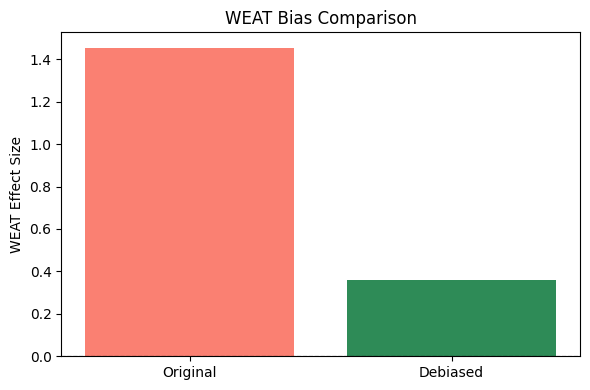

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(['Original', 'Debiased'], [weat_orig, weat_debiased], color=['salmon', 'seagreen'])
plt.ylabel('WEAT Effect Size')
plt.title('WEAT Bias Comparison')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import random
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt

# Cosine similarity
def cos_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# s(w, A, B)
def association(w, A, B, model):
    return np.mean([cos_sim(model[w], model[a]) for a in A]) - \
           np.mean([cos_sim(model[w], model[b]) for b in B])

# Test statistic (raw WEAT score)
def test_stat(X, Y, A, B, model):
    return np.sum([association(x, A, B, model) for x in X]) - \
           np.sum([association(y, A, B, model) for y in Y])

# Effect size
def effect_size(X, Y, A, B, model):
    s_X = [association(x, A, B, model) for x in X]
    s_Y = [association(y, A, B, model) for y in Y]
    return (np.mean(s_X) - np.mean(s_Y)) / np.std(s_X + s_Y)

# Permutation-based p-value
def weat_p_value(X, Y, A, B, model, n_samples=10000):
    joint = X + Y
    size = len(X)
    observed = test_stat(X, Y, A, B, model)

    more_extreme = 0
    for _ in tqdm(range(n_samples), desc="Running permutations"):
        random.shuffle(joint)
        X_i, Y_i = joint[:size], joint[size:]
        s_i = test_stat(X_i, Y_i, A, B, model)
        if abs(s_i) > abs(observed):
            more_extreme += 1

    return more_extreme / n_samples


In [ ]:
def run_weat_test(name, X, Y, A, B, model):
    es = effect_size(X, Y, A, B, model)
    p = weat_p_value(X, Y, A, B, model, n_samples=1000)
    print(f"{name} → Effect size: {es:.4f}, p-value: {p:.4f}")
    return es, p

# WEAT 1: Arts vs Science
X1 = ['math', 'physics', 'chemistry', 'astronomy']
Y1 = ['poetry', 'literature', 'novel', 'art']
A1 = ['man', 'male', 'he', 'him']
B1 = ['woman', 'female', 'she', 'her']

# WEAT 6: Career vs Family
X2 = ['executive', 'management', 'professional', 'corporation']
Y2 = ['home', 'parents', 'children', 'family']
A2 = ['man', 'male', 'he', 'him']
B2 = ['woman', 'female', 'she', 'her']

# Custom: Male vs Female professions (from PCA list)
X3 = ['engineer', 'scientist', 'programmer', 'doctor']
Y3 = ['nurse', 'maid', 'secretary', 'teacher']
A3 = ['he', 'him', 'man']
B3 = ['she', 'her', 'woman']

# Run tests on original model
print("ORIGINAL EMBEDDINGS")
results_orig = [
    run_weat_test("WEAT 1 (Science vs Arts)", X1, Y1, A1, B1, word2vec_model),
    run_weat_test("WEAT 6 (Career vs Family)", X2, Y2, A2, B2, word2vec_model),
    run_weat_test("Custom Professions vs Gender", X3, Y3, A3, B3, word2vec_model)
]

# Run tests on debiased
# Prepare dictionary of debiased vectors
all_words = list(set(X1 + Y1 + A1 + B1 + X2 + Y2 + A2 + B2 + X3 + Y3 + A3 + B3))
deb = {w: loaded_model.debias(word2vec_model[w]) for w in all_words if w in word2vec_model}

print("\n DEBIASED EMBEDDINGS")
results_deb = [
    run_weat_test("WEAT 1 (Science vs Arts)", X1, Y1, A1, B1, deb),
    run_weat_test("WEAT 6 (Career vs Family)", X2, Y2, A2, B2, deb),
    run_weat_test("Custom Professions vs Gender", X3, Y3, A3, B3, deb)
]


ORIGINAL EMBEDDINGS


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1073.00it/s]


WEAT 1 (Science vs Arts) → Effect size: 1.7786, p-value: 0.0000


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1084.93it/s]


WEAT 6 (Career vs Family) → Effect size: 1.4278, p-value: 0.0000


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1314.67it/s]


Custom Professions vs Gender → Effect size: 1.3738, p-value: 0.0840

 DEBIASED EMBEDDINGS


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1320.83it/s]


WEAT 1 (Science vs Arts) → Effect size: -1.5365, p-value: 0.0400


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1332.46it/s]


WEAT 6 (Career vs Family) → Effect size: -1.6273, p-value: 0.0000


Running permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1568.79it/s]

Custom Professions vs Gender → Effect size: -0.0340, p-value: 0.9520


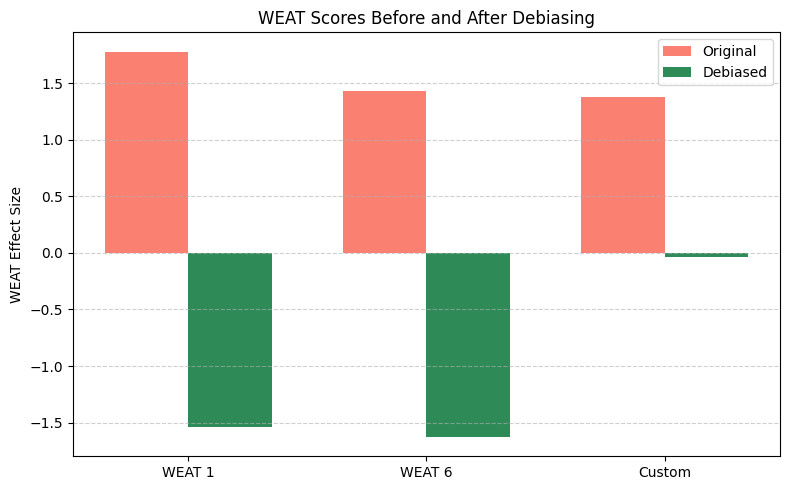

In [ ]:
labels = ['WEAT 1', 'WEAT 6', 'Custom']
es_orig = [r[0] for r in results_orig]
es_deb = [r[0] for r in results_deb]

x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - bar_width/2, es_orig, bar_width, label='Original', color='salmon')
plt.bar(x + bar_width/2, es_deb, bar_width, label='Debiased', color='seagreen')
plt.xticks(x, labels)
plt.ylabel("WEAT Effect Size")
plt.title("WEAT Scores Before and After Debiasing")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
def analogy(a,b,c,trained_model):
  biased=-word2vec_model[a]+word2vec_model[b]+word2vec_model[c]
  print("Original 4th word completing analogy")
  print(word2vec_model.similar_by_vector(biased,topn=5))
  debiased=trained_model.debias(biased)
  print("Debiased 4th word completing analogy")
  print(word2vec_model.similar_by_vector(debiased,topn=5))


In [ ]:
analogy('man','woman','smart',loaded_model)

Original 4th word completing analogy
[('smart', 0.7897845506668091), ('woman', 0.4911803603172302), ('intelligent', 0.4911749064922333), ('sexy', 0.4470319449901581), ('savvy', 0.43911200761795044)]
Debiased 4th word completing analogy
[('smarter', 0.6132714152336121), ('smartest', 0.5629914402961731), ('smart', 0.4367319345474243), ('efficient', 0.4107448160648346), ('easiest', 0.40013763308525085)]


In [ ]:
print(word2vec_model.most_similar("soldier",topn=5))
print(word2vec_model.most_similar(loaded_model.debias("soldier"),topn=5))

[('soldiers', 0.7162267565727234), ('wounded', 0.6503106355667114), ('policeman', 0.6371234655380249), ('army', 0.5879427194595337), ('killed', 0.55167555809021)]
[('young', 0.4433738589286804), ('who', 0.42099475860595703), ('men', 0.418893426656723), ('woman', 0.40519222617149353), ('teenagers', 0.4020405411720276)]
